In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# Questions

1. Build a model which is better than the bank model.
2. Using the (-1,1,0) rule, compare bank profitability vs your model profitability
3. Most important variable and how does "is_employed" impact the model 
4. Other variables to include?

Load data

In [2]:
borrower = pd.read_csv("borrower_table.csv")
loan = pd.read_csv("loan_table.csv")
print("Borrower table: ", borrower.shape)
print("loan table: ", loan.shape)

print("Are all loan ids in borrower table unique: ", len(borrower) == len(borrower['loan_id'].unique()))
print("Are all loan ids in loan table unique: ", len(loan) == len(loan['loan_id'].unique()))

Borrower table:  (101100, 12)
loan table:  (101100, 5)
Are all loan ids in borrower table unique:  True
Are all loan ids in loan table unique:  True


1. 54947 of all loans is the first time
2. 53446 loan applications are not granted
3. There are 6972 missing values in avg_percentage_credit_card

In [3]:
#join two tables and check null values other than 'l_r, f_r_p_l, c_r_o_l'
data = pd.merge(borrower, loan, on = 'loan_id', how = 'inner')

print("new data has shape: ", data.shape, '\n')
print(data.isnull().sum())

new data has shape:  (101100, 16) 

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                        53446
dtype: int64


Our goal is to maximize the profit of those who are granted loan, so we remove those who are not granted, and create a new column, which will be the label of our model, **should_grant**

In [4]:
data = data[data['loan_granted'] == 1]
data['should_grant'] = data.apply(lambda row: 1 if row['loan_repaid']==1 else 0, axis =1)

In [5]:
#some data type transformation
median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data['avg_percentage_credit_card_limit_used_last_year'].fillna(median, inplace = True)
#drop 2 useless columns
to_drop = ['loan_id','loan_granted']
data.drop(to_drop, axis=1, inplace = True)
data['date'] = pd.to_datetime(data['date'])

In [6]:
data.head(3)

,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,date,loan_repaid,should_grant
2,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8,other,2012-07-16,1.0,1
5,1,NaN,NaN,6100,0.53,6163,5298,1,29500,24,1,other,2012-11-07,1.0,1
7,1,NaN,NaN,4000,0.57,602,2757,1,31700,36,8,business,2012-09-19,0.0,0


## Exploratory data analysis 

Text(0.5,1,'First loan vs. should grant ratio')

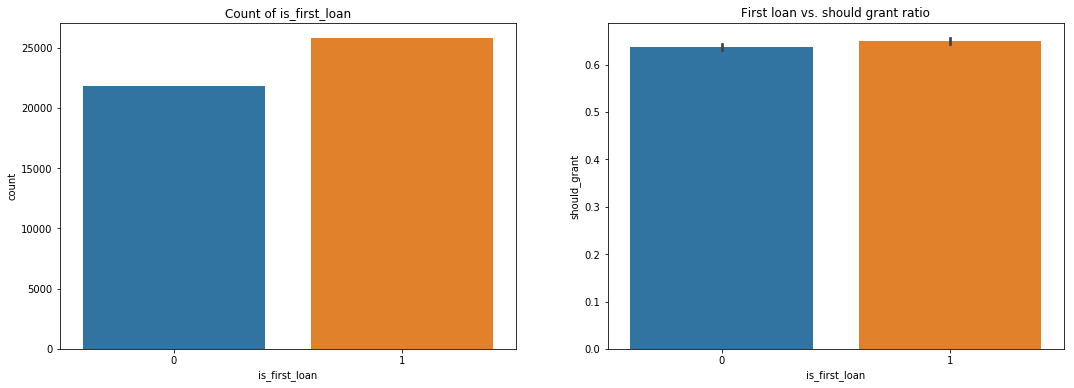

In [7]:
#is_first_loan, take a look at its distribution
fig, ax = plt.subplots(nrows = 1,ncols=2,figsize = (18,6))

sns.countplot(x = 'is_first_loan', ax = ax[0],data = data)
ax[0].set_title("Count of is_first_loan")

sns.barplot(x = 'is_first_loan', ax = ax[1], y = 'should_grant', data=data)
ax[1].set_title("First loan vs. should grant ratio")

Analyze four bank card related features:  *total_credit_card_limit*, *avg_percentage_credit_card_limit_used_last_year*, *checking_amount*, *saving_amount*

1. 2 credit card features play important role in deciding if should grant loan because those who are granted have higher credit_card limit and less percentage of use

2. **checking, saving amount** is also distinguishable

Text(0.5,1,'Histogram of saving amount vs. should grant rate')

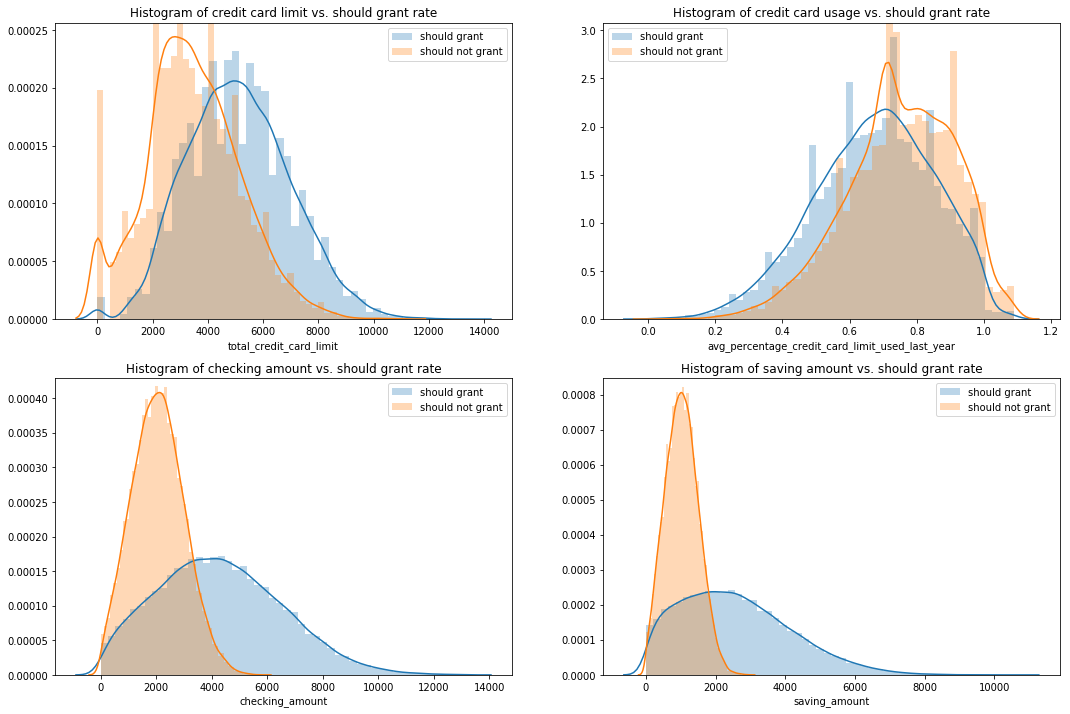

In [8]:
#credit card limit
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (18,12))
hist_kws={"alpha": 0.3}
#credit card
sns.distplot(a = data[data['should_grant']==1]['total_credit_card_limit'], ax=ax1,hist_kws=hist_kws)
sns.distplot(a = data[data['should_grant']==0]['total_credit_card_limit'], ax=ax1,hist_kws=hist_kws)
ax1.legend(['should grant','should not grant'])
ax1.set_title("Histogram of credit card limit vs. should grant rate")

#credit card
sns.distplot(a = data[data['should_grant']==1]['avg_percentage_credit_card_limit_used_last_year'], \
             ax=ax2, hist_kws=hist_kws)
sns.distplot(a = data[data['should_grant']==0]['avg_percentage_credit_card_limit_used_last_year'], \
             ax=ax2,hist_kws=hist_kws)
ax2.legend(['should grant','should not grant'])
ax2.set_title("Histogram of credit card usage vs. should grant rate")

#checking account
sns.distplot(a = data[data['should_grant']==1]['checking_amount'], ax=ax3, hist_kws=hist_kws)
sns.distplot(a = data[data['should_grant']==0]['checking_amount'], ax=ax3, hist_kws=hist_kws)
ax3.legend(['should grant','should not grant'])
ax3.set_title("Histogram of checking amount vs. should grant rate")

#saving account
sns.distplot(a = data[data['should_grant']==1]['saving_amount'], ax=ax4, hist_kws=hist_kws)
sns.distplot(a = data[data['should_grant']==0]['saving_amount'], ax=ax4, hist_kws=hist_kws)
ax4.legend(['should grant','should not grant'])
ax4.set_title("Histogram of saving amount vs. should grant rate")

Analyze *fully_repaid_previous_loans* and *currently_repaying_other_loans* by loan_granted. These two features mainly focus on loan history of the borrower, and see how this affects current status

1. For **fully_repaid_previous_loans**, this affects repaid situation because people who have debts in previous loans are less likely to repay
2. For **currently_repaying_other_loans**, this definitely affects loan decision since those who are not currently paying for other loans are much more likely to repay

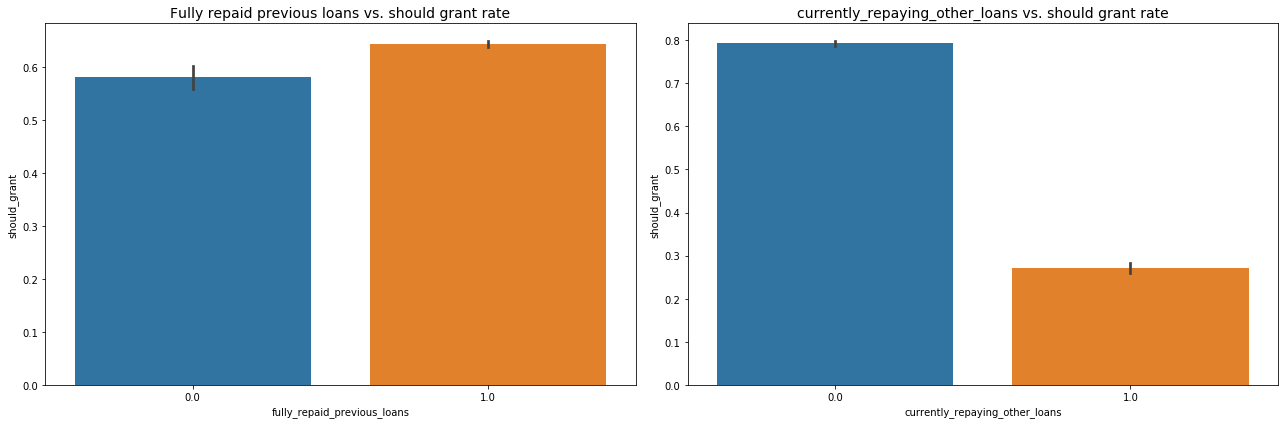

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.barplot(x = 'fully_repaid_previous_loans', y = 'should_grant', data = data, ax = ax[0])
ax[0].set_title("Fully repaid previous loans vs. should grant rate",fontsize=14)

sns.barplot(x = 'currently_repaying_other_loans',data=data, y = 'should_grant', ax = ax[1])
ax[1].set_title("currently_repaying_other_loans vs. should grant rate",fontsize=14)
plt.tight_layout()

Next we analyze effect of employment using *is_employed* and *yearly_salary*

1. **Employment** affects grant rate significantly. Most of those who do not repay are unemployed
2. **Salary** also influences the decision quite a lot. Those who repay on average have higher salaries than those who do not

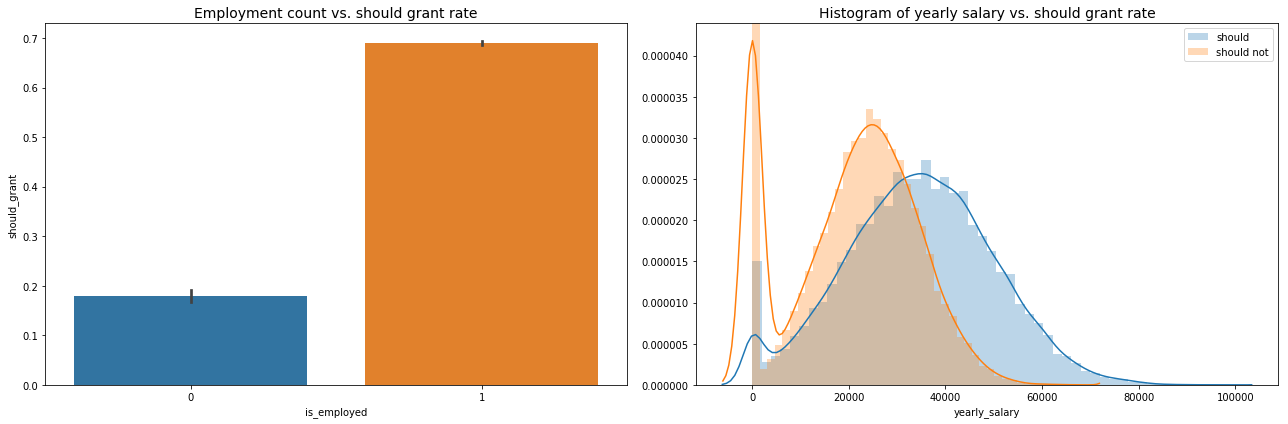

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (18,6))

sns.barplot(x = 'is_employed',data = data, y = 'should_grant', ax = ax[0])
ax[0].set_title("Employment count vs. should grant rate", fontsize = 14)

sns.distplot(a=data[data['should_grant']==1]['yearly_salary'], hist_kws={'alpha':0.3},ax=ax[1])
sns.distplot(a=data[data['should_grant']==0]['yearly_salary'], hist_kws={'alpha':0.3},ax=ax[1])
ax[1].set_title("Histogram of yearly salary vs. should grant rate", fontsize = 14)
ax[1].legend(['should','should not'])
plt.tight_layout()

We then analyze the impact of personal/family information: *age* and *number of dependents*

1. **Age** is quite evenly distributed for two groups. So there is minimal effect
2. **dependent_number** is very indicative. As number of dependents increase, they are less likely to repay

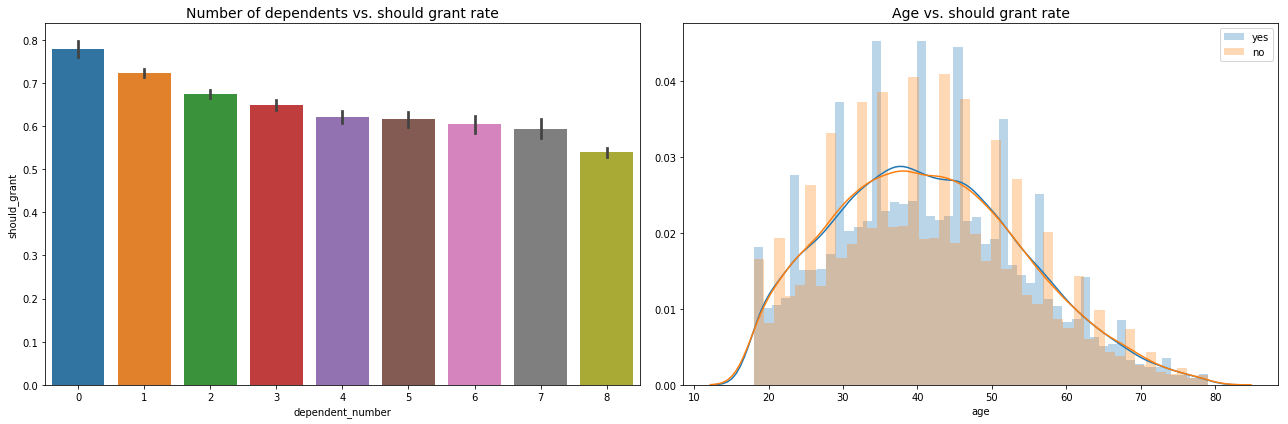

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (18,6))

sns.barplot(x = 'dependent_number',data = data, y = 'should_grant', ax = ax[0])
ax[0].set_title("Number of dependents vs. should grant rate", fontsize = 14)

sns.distplot(a=data[data['should_grant']==1]['age'], hist_kws={"alpha":0.3},ax=ax[1])
sns.distplot(a=data[data['should_grant']==0]['age'], hist_kws={"alpha":0.3},ax=ax[1])
ax[1].set_title("Age vs. should grant rate", fontsize = 14)
ax[1].legend(['yes','no'])
plt.tight_layout()

Next look at the impact of **loan_purpose** <br\> This factor also influences, as business/investment have higher repay possibility, while emergency fund is the lowest

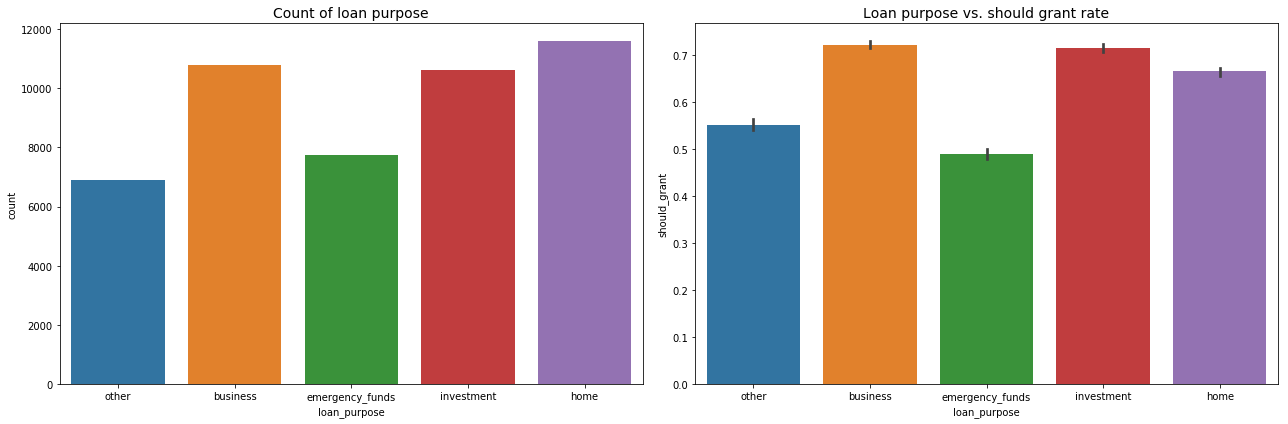

In [12]:
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize=(18,6))
sns.countplot(x='loan_purpose', ax= ax[0],data = data)
ax[0].set_title("Count of loan purpose", fontsize = 14)

sns.barplot(x='loan_purpose', y = 'should_grant', data = data, ax = ax[1])
ax[1].set_title("Loan purpose vs. should grant rate", fontsize = 14)
plt.tight_layout()

Look at the influence of **date**, we extract month, dayofweek to check if there is any seasonality impact<br\>
Effects of these 2 factors are quite minimal

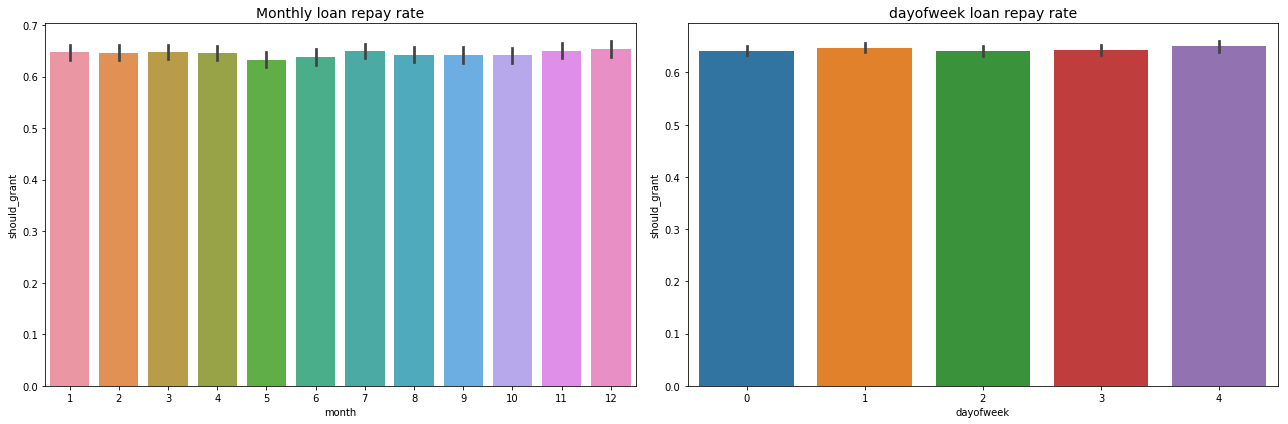

In [13]:
data['month'] = data['date'].apply(lambda d: d.month)
data['dayofweek'] = data['date'].apply(lambda d: d.dayofweek)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
#monthly should grant rate
sns.barplot(x = 'month', y ='should_grant',data=data, ax = ax[0])
ax[0].set_title("Monthly loan repay rate", fontsize = 14)

#dayofweek rate
sns.barplot(x = 'dayofweek', y ='should_grant',data=data, ax = ax[1])
ax[1].set_title("dayofweek loan repay rate", fontsize = 14)

plt.tight_layout()

# Question 1&2

## Feature engineering

In [14]:
#impute null values in fully_repaid and currntly_repaying by -1
data['fully_repaid_previous_loans'].fillna(value = -1, inplace =True)
data['currently_repaying_other_loans'].fillna(value = -1, inplace=True)

In [15]:
#convert them to catogorical 
cols = ['fully_repaid_previous_loans', 'currently_repaying_other_loans', 'is_employed', 'should_grant']
for col in cols:
    data[col] = data[col].astype('category')
#remove age,date,month, dayofweek based on abova analysis results
#also remove is_first_loan since other 2 variables indicate it
to_drop =['age','date','month','dayofweek','is_first_loan']
data.drop(to_drop, inplace = True, axis =1)

In [16]:
#convert loan_purpose to one_hot
purpose = pd.get_dummies(data['loan_purpose'])
names = {col:"purpose_"+col for col in purpose.columns}

data = pd.concat([data, purpose], axis = 1)
data.drop(['loan_purpose','loan_repaid'], axis = 1, inplace = True)
data.rename(columns=names, inplace = True)

In [17]:
data.head(3)

,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,dependent_number,should_grant,purpose_business,purpose_emergency_funds,purpose_home,purpose_investment,purpose_other
2,-1.0,-1.0,6900,0.82,2085,3422,1,24500,8,1,0,0,0,0,1
5,-1.0,-1.0,6100,0.53,6163,5298,1,29500,1,1,0,0,0,0,1
7,-1.0,-1.0,4000,0.57,602,2757,1,31700,8,0,1,0,0,0,0


## Predictive modeling

In [18]:
y = data['should_grant']
X = data.loc[:, data.columns != 'should_grant']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [19]:
y.value_counts()

1    30706
0    16948
Name: should_grant, dtype: int64

In [20]:
#Use GBDT to predict 'should_grant'. And because data is faily imbalanced, we use auc as scoring metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

params = {"learning_rate":[0.01,0.1],"n_estimators":[50,100,500]}
clf = GradientBoostingClassifier()

grid_search = GridSearchCV(clf, params, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [21]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [22]:
#profit of bank's method on test_data
bank_profit = np.sum(y_test.astype('int') * 2 -1)
print("Bank profit on test data: ", bank_profit)

Bank profit on test data:  4093


In [23]:
def get_profits(y_true, probs, threshold):
    preds = (probs[:,0] < threshold).astype('int')
    profit = 0
    for v1, v2 in zip(preds, y_true.values.astype('int')):
        if v1 == 1:
            if v2 == 1:
                profit += 1
            else:
                profit -= 1
    return profit

thresholds = np.linspace(0,1,100)
y_pred = grid_search.predict_proba(X_test)
profits = [get_profits(y_test, y_pred, th) for th in thresholds]

Best cutoff probability point is: 0.44


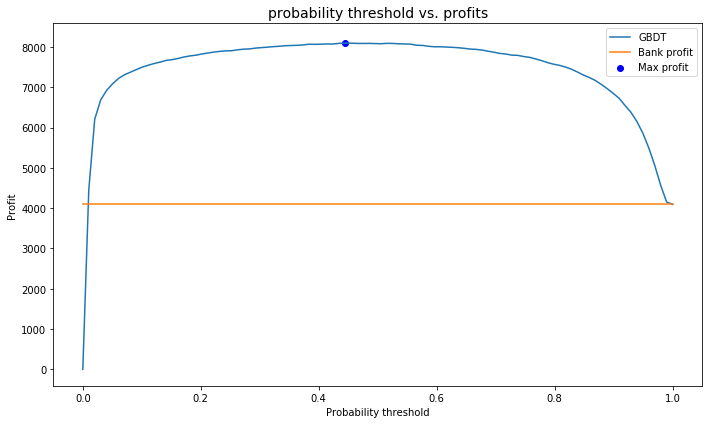

In [24]:
fig,ax = plt.subplots(figsize = (10,6))
ax.plot(thresholds, profits, label = 'GBDT')
ax.plot(thresholds, [bank_profit]*len(thresholds), label = 'Bank profit')
ax.scatter(thresholds[profits.index(max(profits))] ,max(profits), label = 'Max profit', color = "b")
ax.set_xlabel("Probability threshold")
ax.set_ylabel("Profit")
ax.set_title("probability threshold vs. profits",fontsize = 14)
ax.legend()
plt.tight_layout()

print("Best cutoff probability point is: {:.2f}".format(thresholds[profits.index(max(profits))]))

**Q1&2**: When we choose a cutoff point of around 0.44 for this GBDT model, we can see that it outperforms the bank by a large margin

## Question 3
Based on below feature importance plot, we can see that checking/saving amount and credit card related features are most important. *is_employed* has very small influence on the "should grant loan* decision

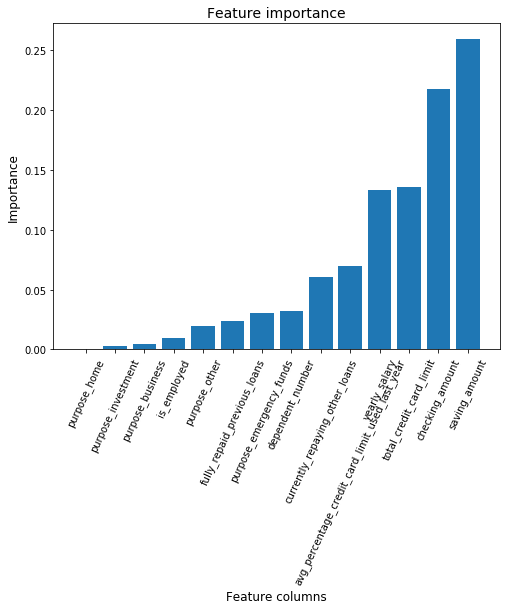

In [25]:
importance = grid_search.best_estimator_.feature_importances_
feature = X.columns
imp_df = pd.DataFrame({"feature": feature, "importance":importance})
imp_df = imp_df.sort_values(by = 'importance').reset_index(drop = True)

fig, ax = plt.subplots(figsize = (8,6))
ax.bar(x = imp_df['feature'], height =imp_df['importance'])
ax.set_title("Feature importance", fontsize = 14)
ax.set_ylabel("Importance", fontsize = 12)
ax.set_xlabel("Feature columns", fontsize = 12)
for tick in ax.get_xticklabels():
    tick.set_rotation(65)

## Question 4
1. One feature that might be very useful is *education level* because the higher education level, the more likely to repay loan because of higher ability to earn more money
2. Another feature that can be useful is *zipcode* information because zipcode often indicates wealth level of a neighborhood, so the more wealthy zipcode this person lives in, the more likely he/she will repay